![CDC Zombies p1](CDC-Zombies-p1.jpg "CDC Zombies p1")
![CDC Zombies p21](CDC-Zombies-p21.jpg "CDC Zombies p21")

---
### Let's start by importing some basic packages
* **Starsim** is our new agent-based disease modeling framework. [Starsim source code](http://starsim.org) is open source and freely available. See also our emerging [online documentation and tutorials](https://docs.idmod.org/projects/starsim/en/latest/).
* **zombie** is all the stuff we'll need to do zombie simulations
* Other imports are for numerical operations (**numpy**, **pandas**), convenience (**sciris**), and plotting (**seaborn**, **matplotlib**)
---

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import starsim as ss
from zombie import *
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

import sciris as sc
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
pyplot.rcParams['figure.dpi'] = 120

Starsim 0.5.4 (2024-06-11) — © 2023-2024 by IDM


---
### Basic SIR simulation using the Starsim framework

* We choose 5,000 agents, of which 5% are selected at random to be "seed" infections.
* The disease will transmit on a "random" network in the sense that contacts between agents will be recreated on every time step. The number of contacts will be Poisson distributed with a mean of 4.
* The simulation runs in a fraction of a second.
* We then plot some default channels.
---

Initializing sim with 5000 agents
  Running 2000.0 ( 0/51) (1.38 s)  ———————————————————— 2%
  Running 2010.0 (10/51) (1.40 s)  ••••———————————————— 22%
  Running 2020.0 (20/51) (1.42 s)  ••••••••———————————— 41%
  Running 2030.0 (30/51) (1.44 s)  ••••••••••••———————— 61%
  Running 2040.0 (40/51) (1.46 s)  ••••••••••••••••———— 80%
  Running 2050.0 (50/51) (1.48 s)  •••••••••••••••••••• 100%



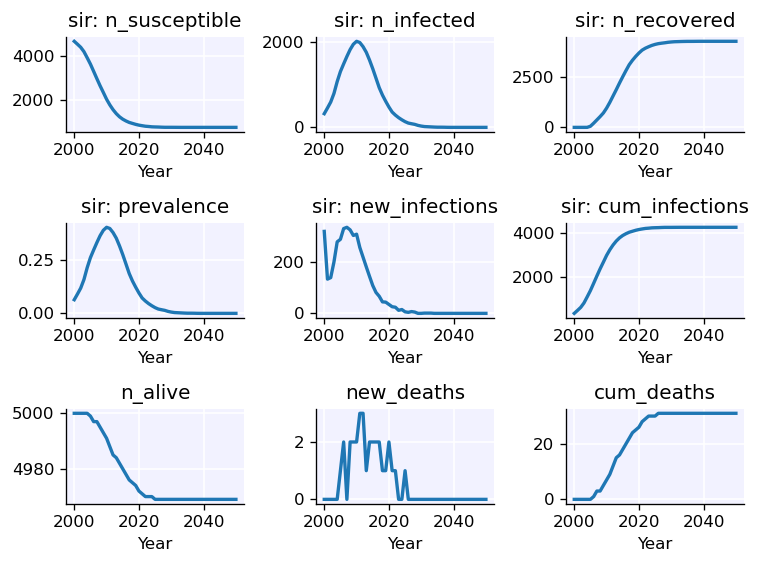

In [2]:
people = ss.People(n_agents=5_000)
sir = ss.SIR(init_prev=0.05, beta=0.1)
network = ss.RandomNet(n_contacts=ss.poisson(lam=4))
sim = ss.Sim(people=people, diseases=sir, networks=network)
sim.run()
sim.plot();

---
### That was easy, but we want ZOMBIES!!!
* **Zombie** is a simple extension of the SIR disease that adds some important features:
  * **p_fast** is the probability of zombie being fast, choosing 10% here based on my research. Fast zombies have a mean of 10 contacts as compared to 4 for slow zombies.
  * **dur_fast** is the duration of a zombie being fast before reverting to slow, default 1000 years.
  * **dur_inf** is the duration of zombie infection, default is 1000 years. Once a zombie, always a zombie!
  * **p_symptomatic** is the probability of showing symptoms, default assumption is 100%
  * **p_death_on_zombie_infection** is the probability of death when converting to a zombie, 50% might be a bit high based on my research!

* **DeathZombies** is an extension of the base **Deaths** demographic class that captures people at natural death and potentially makes them zombies
  * **p_zombie_on_natural_death** is the probability of becoming a zombie on death due to natural causes

* We include an intervention, **KillZombies** that kills *symptomatic* zombies at a rate of 0.5/year.

* Configuring and running the simulation from 2024 to 2040 takes less than one second.
* Showing built-in plots, although it is easy to generate alternative figures stored in sim.results.
---

In [16]:
people = ss.People(n_agents=5_000)

zombie_pars = dict(
    init_prev = 0.05,
    beta = {'random': 0.1, 'maternal': 100},
    p_fast = ss.bernoulli(p=0.10),
    p_death_on_zombie_infection = ss.bernoulli(p=0.5),
    p_symptomatic = ss.bernoulli(p=1.0),
)
zombie = Zombie(zombie_pars)

def choose_degree(self, sim, uids):
    mean_degree = np.full(fill_value=4, shape=len(uids))
    zombie = sim.diseases['zombie']
    mean_degree[zombie.fast[uids]] = 10
    return mean_degree

networks = [
    ss.RandomNet(n_contacts=ss.poisson(lam=choose_degree)),
    ss.MaternalNet()
]

death_pars = dict(
    death_rate = 15, # per 1,000
    p_zombie_on_natural_death = ss.bernoulli(p=0),
)
deaths = DeathZombies(**death_pars)
births = ss.Pregnancy(fertility_rate=175) # per 1,000 women 15-49
demog = [births, deaths]

killzombies = KillZombies(year=2024, rate=0.5)

sim_pars = dict(start=2024, end=2040, dt=0.5)
sim = ss.Sim(sim_pars, people=people, diseases=zombie, networks=networks, demographics=demog, interventions=killzombies, analyzers=ZombieAnalyzer())
sim.run()
sim.plot('zombie')
sim.plot('deathzombies');

Initializing sim with 5000 agents


TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
# We can also look at how many congenital zombies there were
fig, ax = plt.subplots()
az = sim.get_analyzer('zombieanalyzer')
df = az.df
g = sns.lineplot(df, x='year', y='cum_congenital', ax=ax)

---
# Empirical data on Zombies is sparse...
Here we compare default assumptions (same as above) to the following 4 alternatives:

0. Default assumptions
1. 75% of zombies are fast (as opposed to 25%)
2. Fast zombies slow down after about 2 years
3. The infectious period is about 10 years instead of forever
4. 75% of zombies are asymptomatic, so the KillZombies intervention will be less effective
5. 10% die on zombie infection, down from 50% default assumption.
6. 75% of people dieing of natural causes become a zombie, up from none.
---

In [ ]:
# Start by creating a dictionary of the scenarios
scens = {
    'DefaultAssumptions': {},
    'More Fast Zombies': {'zombie_pars': dict(p_fast=ss.bernoulli(p=0.75))},
    'Fast-->Slow Zombies': {'zombie_pars': dict(p_fast=ss.bernoulli(p=0.75), dur_fast=ss.weibull(c=2, scale=2))},
    'Shorter Infectious Period': {'zombie_pars': dict(dur_inf=ss.normal(loc=5, scale=2))},
    'All Zombies Asymptomatic': {'zombie_pars': dict(p_symptomatic=ss.bernoulli(p=0))},
    'Less Death on Zombie Infection': {'zombie_pars': dict(p_death_on_zombie_infection=ss.bernoulli(p=0.10))},
    'Half Zombie on Natural Death': {'death_pars': dict(p_zombie_on_natural_death=ss.bernoulli(p=0.5))},
    'REALLY BAD': {'zombie_pars': dict(p_fast=ss.bernoulli(p=1.0), p_symptomatic=ss.bernoulli(p=0), p_death_on_zombie_infection=ss.bernoulli(p=0.90)),
                   'death_pars': dict(p_zombie_on_natural_death=ss.bernoulli(p=1.0))},
}

In [ ]:
# Now make a function that configures and runs a zombie simulation, taking inputs from the user.
# When the run is complete, results are returned as a dataframe.
def run_zombies(scen, rand_seed, zombie_pars=None, death_pars=None, intvs=[], **kwargs):
    people = ss.People(n_agents=5_000)

    zombie_pars = sc.mergedicts(dict(
        init_prev = 0.03,
        beta = {'random': 0.05, 'maternal': 10},
        p_fast = ss.bernoulli(p=0),
        p_death_on_zombie_infection = ss.bernoulli(p=0.5),
        p_symptomatic = ss.bernoulli(p=1.0),
    ), zombie_pars)
    zombie = Zombie(zombie_pars)

    def choose_degree(self, sim, uids):
        mean_degree = np.full(fill_value=4, shape=len(uids))
        is_fast = (sim.diseases['zombie'].infected[uids]) & (sim.diseases['zombie'].fast[uids])
        mean_degree[is_fast] = 50
        return mean_degree

    networks = [
        ss.RandomNet(n_contacts=ss.poisson(lam=choose_degree)),
        ss.MaternalNet()
    ]

    death_pars = sc.mergedicts(dict(
        death_rate = 15, # per 1,000
        p_zombie_on_natural_death = ss.bernoulli(p=0),
    ), death_pars)
    deaths = DeathZombies(**death_pars)
    births = ss.Pregnancy(fertility_rate=175) # per 1,000 women 15-49
    demog = [births, deaths]

    interventions = KillZombies(year=2024, rate=0.1)
    interventions = [interventions] + sc.promotetolist(intvs) # Add interventions passed in

    sim_pars = dict(start=2024, end=2040, dt=0.5, rand_seed=rand_seed, label=scen, verbose=0)
    sim = ss.Sim(sim_pars, people=people, diseases=zombie, networks=networks, demographics=demog, interventions=interventions)
    sim.run()

    # Package results
    df = pd.DataFrame( {
        'Year': sim.yearvec,
        'Population': sim.results.n_alive,
        'Deaths': sim.results.cum_deaths,
        'Zombies': sim.results.zombie.n_infected,
        'Zombie Prevalence': sim.results.zombie.prevalence,
        #'Congential Zombies': sim.results.pregnancy.asdf
    })
    df['rand_seed'] = rand_seed
    df['Scen'] = scen
    for key, val in kwargs.items():
        df[key] = val

    return df

In [ ]:
# Now run all the scenarios in parallel, repeating each configuration 10 times.
n_repeats = 10

results = []
cfgs = []

for skey, scen in scens.items():
    for rand_seed in range(n_repeats):
        cfgs.append({'scen': skey, 'rand_seed':rand_seed} | scen) # Merge dicts with pipe operators

T = sc.tic()
results += sc.parallelize(run_zombies, iterkwargs=cfgs)
print(f'That took: {sc.toc(T, output=True):.1f}s')
df = pd.concat(results).replace(np.inf, np.nan)

# Display the top of the results data frame
display(df.head())

In [ ]:
# Manipulate the data and create a plot using the Seaborn library
dfm = df.melt(id_vars=['Scen', 'Year', 'rand_seed'], value_vars=['Population', 'Zombies', 'Zombie Prevalence', 'Deaths'], var_name='Channel', value_name='Value')
g = sns.relplot(kind='line', data=dfm, col='Channel', x='Year', y='Value', hue='Scen', facet_kws=dict(sharey=False))

---
### That's alarming! What can we do to slow the spread of zombies?
* Let's consider a vaccine intervention, and see how well it works in each scenario.
---

In [ ]:
# Create a vaccine intervention
antizombie_vx = zombie_vaccine(efficacy = 0.7)
vx_intv = ss.campaign_vx(
    product = antizombie_vx,
    years = [2028],  # Begin year
    prob = [0.6],    # Coverage
)

# Revise scenarios to see impact of the vaccine
scens_vx = {}
for skey, scen in scens.items():
    scens_vx[skey] = scen.copy()
    scens_vx[skey]['intvs'] = [vx_intv]

In [ ]:
results = []
cfgs = []

for skey, scen in scens_vx.items():
    for rand_seed in range(n_repeats):
        cfgs.append({'scen': skey,'rand_seed':rand_seed} | scen) # Merge dicts with pipe operators

T = sc.tic()
results += sc.parallelize(run_zombies, iterkwargs=cfgs)
print(f'That took: {sc.toc(T, output=True):.1f}s')
df_vx = pd.concat(results)

# Combine results
df['Vx'] = False
df_vx['Vx'] = True
df_all = pd.concat([df, df_vx])

In [ ]:
dfm = df_all.melt(id_vars=['Scen', 'Vx', 'Year', 'rand_seed'], value_vars=['Zombie Prevalence', 'Deaths'], var_name='Channel', value_name='Value')
g = sns.relplot(kind='line', data=dfm, col='Channel', x='Year', y='Value', hue='Scen', style='Vx', facet_kws=dict(sharey=False));

In [ ]:
people = ss.People(n_agents=5_000)

slow_zombie_pars = dict(
    init_prev = 0.05,
    beta = 0.1,
    p_fast = ss.bernoulli(p=0),
    p_death_on_zombie_infection = ss.bernoulli(p=0.0),
    p_symptomatic = ss.bernoulli(p=1.0), # 1.0
)
slow_zombie = Zombie(slow_zombie_pars, name='slow_zombie')

fast_zombie_pars = slow_zombie_pars.copy()
fast_zombie_pars['p_fast'] = ss.bernoulli(p=1)
#fast_zombie_pars['beta'] = 0.01
fast_zombie = Zombie(fast_zombie_pars, name='fast_zombie')

connector = ZombieConnector()

def choose_degree(self, sim, uids):
    mean_degree = np.full(fill_value=4, shape=len(uids))
    is_fast = ((sim.diseases['fast_zombie'].infected[uids]) & (sim.diseases['fast_zombie'].fast[uids])) | \
              ((sim.diseases['slow_zombie'].infected[uids]) & (sim.diseases['slow_zombie'].fast[uids]))
    mean_degree[is_fast] = 50
    return mean_degree
'''
def choose_degree(self, sim, uids):
    mean_degree = np.full(fill_value=4, shape=len(uids))
    zombie = sim.diseases['zombie']
    mean_degree[zombie.fast] = 10
    return mean_degree
'''

#network = ss.RandomNet(n_contacts=ss.poisson(lam=choose_degree))
network = ss.RandomNet(n_contacts=ss.constant(v=choose_degree))

death_pars = dict(
    death_rate = 20,
    p_zombie_on_natural_death = ss.bernoulli(p=0.5),
)
demog = DeathZombies(**death_pars)

killzombies = KillZombies(year=2024, rate=0.5)

sim_pars = dict(start=2024, end=2040, dt=0.5)
sim = ss.Sim(sim_pars, people=people, diseases=[fast_zombie, slow_zombie], networks=network, demographics=demog, interventions=killzombies, connectors=connector)
sim.run()
sim.plot('fast_zombie')
sim.plot('slow_zombie')
sim.plot('deathzombies');